In [1]:
from setGPU import setGPU
setGPU()

setGPU: Setting GPU to: 3


In [2]:
random_state = 999

n_classes = 3
n_features = 2  # Number of features
n_samples = 1100  # Number of samples
centers = [[-2, 0], [2, -2], [2, 2]]  # Centers of the clusters
cluster_std = 0.8  # Standard deviation of the clusters

In [3]:
# experiment parameters
n_classes = 3
n_features = 2
n_samples_tr = 4000  # number of training set samples
n_samples_ts = 1000  # number of testing set samples
batch_size = 20

# dataset creation
from secml.data.loader import CDLRandom
dataset = CDLRandom(n_samples=n_samples_tr + n_samples_ts,
                    n_classes=n_classes,
                    n_features=n_features, n_redundant=0,
                    n_clusters_per_class=1,
                    class_sep=1, random_state=0).load()

# Split in training and test
from secml.data.splitter import CTrainTestSplit
splitter = CTrainTestSplit(train_size=n_samples_tr,
                           test_size=n_samples_ts,
                           random_state=0)

tr, ts = splitter.split(dataset)

# Normalize the data
from secml.ml.features.normalization import CNormalizerMinMax
nmz = CNormalizerMinMax()
tr.X = nmz.fit_transform(tr.X)
ts.X = nmz.transform(ts.X)

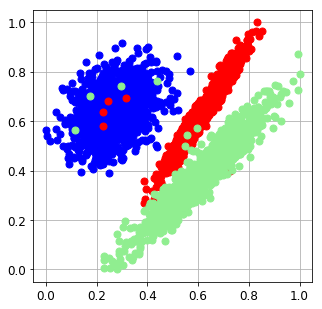

In [4]:
from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(width=5, height=5)

# Convenience function for plotting a dataset
fig.sp.plot_ds(tr)

fig.show()

### Export data in numpy format

In [5]:
from keras.utils import to_categorical

Using TensorFlow backend.


In [6]:
X_tr, y_tr = tr.X.tondarray(), to_categorical(tr.Y.tondarray())
X_ts, y_ts = ts.X.tondarray(), to_categorical(ts.Y.tondarray())

In [7]:
X_tr.shape, y_tr.shape, X_ts.shape, y_ts.shape

((4000, 2), (4000, 3), (1000, 2), (1000, 3))

# Classifying blobs

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from keras.losses import CategoricalCrossentropy

In [9]:
dnn = Sequential()
dnn.add(Dense(5, input_shape=(n_features,), activation='relu', name='fc1'))
dnn.add(Dense(n_classes, name='fc2'))
dnn.add(Activation('softmax'))

dnn.compile(
    SGD(lr=0.001, momentum=0.9),
    loss=CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [10]:
dnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 5)                 15        
_________________________________________________________________
fc2 (Dense)                  (None, 3)                 18        
_________________________________________________________________
activation_1 (Activation)    (None, 3)                 0         
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


In [11]:
# clf.verbose = 1  # Can be used to display training process output
print("Training started...")
dnn.fit(X_tr, y_tr, epochs=50, verbose=0)
print("Training completed!")

Training started...
Training completed!


In [12]:
 # Compute performance on test data
acc = dnn.evaluate(X_ts, y_ts, verbose=0)[1]
print('Classifier test accuracy: {0:.3f}'.format(acc))

Classifier test accuracy: 0.964


# Generate Adversarial Samples

In [13]:
import sys
sys.path.append("/home/crecchi/AE_Detector/ESANN19/AE_Detector")

In [14]:
from attacks import PGD

In [60]:
X_adv = PGD(dnn, eps=1.0, eps_iter=1e-2, nb_iter=100, ord=2).generate(X_ts[:500])

In [61]:
X_adv.shape

(500, 2)

In [62]:
attack_ds = {}
attack_ds['X'] = X_ts[:500]
attack_ds['Y'] = y_ts[:500]

In [63]:
# Compute performance on test data
acc = dnn.evaluate(attack_ds['X'], attack_ds['Y'], verbose=0)[1]
acc_attack = dnn.evaluate(X_adv, attack_ds['Y'], verbose=0)[1]

print("Accuracy on reduced test set before attack: {:.2%}".format(acc))
print("Accuracy on reduced test set after attack: {:.2%}".format(acc_attack))

Accuracy on reduced test set before attack: 97.40%
Accuracy on reduced test set after attack: 15.20%


# Security evaluation of a classifier

In [19]:
from utils import generate_attack_samples

In [20]:
import numpy as np

In [21]:
eps = np.arange(0, 1.01, 0.05)

In [22]:
attack_data = generate_attack_samples(dnn, [PGD], eps, attack_ds['X'], attack_ds['Y'])

- PGD:


 43%|████▎     | 9/21 [00:33<00:47,  3.93s/it]

KeyboardInterrupt: 

In [ ]:
from utils import compute_security_curves, plot_security_curves

In [ ]:
attacks = np.array(list(attack_data.keys()))
eps = np.array(sorted(attack_data[attacks[0]].keys()))

In [ ]:
sec_eval = compute_security_curves(dnn, attack_data, attack_ds['Y'], attacks, eps)
sec_eval

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_security_curves(ax1, attacks, eps, sec_eval[0], xlabel='$\epsilon$', ylabel='Accuracy')
plot_security_curves(ax2, attacks, eps, sec_eval[1], xlabel='$\epsilon$', ylabel='Rejection rate')
ax1.set_title('DNN SecEval')
fig.show()

---

In [ ]:
import sys
import logging
logger = logging.getLogger('mylogger')
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler(stream=sys.stdout))

In [ ]:
from detectors import MultilayerDetector

In [ ]:
detector = MultilayerDetector(dnn, ['fc2', 'fc1'])

In [ ]:
detector.fit(X_tr, y_tr)

## Setup Threhsold

In [ ]:
detector.threshold = 1.1

In [ ]:
from sklearn.metrics import accuracy_score

# Compute predictions on a test set
y_pred = detector.predict(X_ts).argmax(1)

# Evaluate the accuracy of the classifier
acc = accuracy_score(y_true=y_ts.argmax(1), y_pred=y_pred)

print("Accuracy on test set: {:.2%}".format(acc))

In [ ]:
fpr = (y_pred == n_classes).sum() / y_pred.shape[0]
fpr

# Test it against BB adversarial samples

In [ ]:
sec_eval_det = compute_security_curves(detector, attack_data, attack_ds['Y'], attacks, eps)
sec_eval_det

In [ ]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_security_curves(ax1, attacks, eps, sec_eval_det[0], xlabel='$\epsilon$', ylabel='Accuracy')
plot_security_curves(ax2, attacks, eps, sec_eval_det[1], xlabel='$\epsilon$', ylabel='Rejection rate')
ax1.set_title('Detector SecEval')
fig.show()